# Preprocessing: Cropping, Interpolation, and Concatenation

Data streams from Neon devices (e.g., gaze, eye states, IMU) often present challenges during analysis. The sampling may be irregular due to device limitations, streams may have different sampling rates, and timestamps may not be synchronized. These issues add complexity to continuous data analysis and sensor fusion.

This tutorial demonstrates how to handle these issues by cropping and restricting streams to time windows of interest, interpolating data to regular sampling, and concatenating multiple streams into a single DataFrame. We will use the same dataset as in the [previous tutorial](read_recording_cloud.ipynb).

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pyneon import Dataset, get_sample_data

dataset = Dataset(get_sample_data("simple", format="native"))

Let's load the streams from the recording. Gaze, eye states and IMU data are `Stream` objects that contain continuous time-series data indexed by timestamps in nanoseconds.

In [2]:
rec = dataset.recordings[0]
gaze = rec.gaze
eye_states = rec.eye_states
imu = rec.imu

# Define a function to visualize the timestamp distribution across streams
def plot_timestamps(gaze, eye_states, imu, concat_stream=None):
    _, ax = plt.subplots(figsize=(8, 2))
    ax.scatter(gaze.ts, np.ones_like(gaze.ts), s=5)
    ax.scatter(eye_states.ts, np.ones_like(eye_states.ts) * 2, s=5)
    ax.scatter(imu.ts, np.ones_like(imu.ts) * 3, s=5)
    # If a concatenated stream (explained later) is provided, plot its timestamps as well
    if concat_stream is not None:
        ax.scatter(concat_stream.ts, np.ones_like(concat_stream.ts) * 4, s=5)
        ax.set_yticks([1, 2, 3, 4])
        ax.set_yticklabels(["Gaze", "Eye states", "IMU", "Concatenated"])
        ax.set_ylim(0.5, 4.5)
    else:
        ax.set_yticks([1, 2, 3])
        ax.set_yticklabels(["Gaze", "Eye states", "IMU"])
        ax.set_ylim(0.5, 3.5)
    ax.set_xlabel("Timestamp (ns)")
    plt.show()

## Temporal Cropping and Restriction of Streams

Sometimes you need to work with specific time windows within your data. PyNeon provides two complementary methods: `crop()` for selecting a time range directly, and `restrict()` for aligning one stream to another's temporal range.

### The `crop()` Method

The `crop()` method extracts data from a stream within a specified temporal range. It offers flexibility through the `by` parameter to define the range in different ways:
- `by="timestamp"`: Use Unix timestamps in nanoseconds (absolute time)
- `by="time"`: Use relative time in seconds from the stream's start
- `by="sample"`: Use sample indices

Let's examine the initial samples from each stream, where irregular sampling often occurs due to device boot-up:

In [3]:
# Crop to the first 0.3 seconds of gaze data using relative time
gaze_begin = gaze.crop(tmin=0, tmax=0.3, by="time")
# Alternatively, crop to the first 200 data points
gaze_begin_by_sample = gaze.crop(tmin=0, tmax=200, by="sample")

print(f"Gaze stream length before cropping: {len(gaze)}")
print(f"Gaze stream length after cropping (0.3 seconds): {len(gaze_begin)}")
print(f"Gaze stream length after cropping (200 samples): {len(gaze_begin_by_sample)}")

Gaze stream length before cropping: 1048
Gaze stream length after cropping (0.3 seconds): 60
Gaze stream length after cropping (200 samples): 200


### The `restrict()` Method

The `restrict()` method provides a convenient way to align one stream's data to another stream's temporal range. It's equivalent to calling `crop(tmin=other.first_ts, tmax=other.last_ts)` where `first_ts` and `last_ts` are the first and last timestamps of the reference stream. This is useful when you want to ensure temporal alignment between multiple streams.

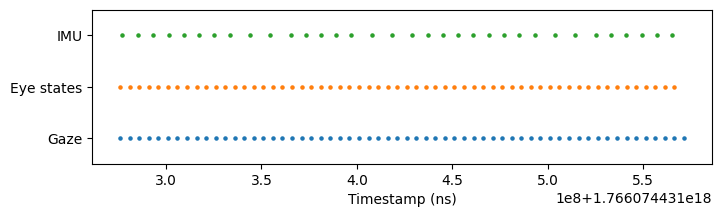

In [4]:
# Restrict eye_states and imu data to match gaze_begin's time range
eye_states_begin = eye_states.restrict(gaze_begin)
imu_begin = imu.restrict(gaze_begin)

plot_timestamps(gaze_begin, eye_states_begin, imu_begin)

## Analyzing Irregular Sampling Patterns

Notice in the visualization above how the restricted streams have different timestamp distributions—they don't share uniform spacing. How frequent are sampling irregularities? We examine the distribution of time differences between consecutive samples and compare them to the nominal (expected) sampling rate specified by Pupil Labs:


In addition to dropouts, irregular sampling may also occur. This is particularly visible in the middle section of the recording (around 3-3.3 seconds), where we can see the variation in sampling intervals:

Nominal sampling frequency of gaze: 200 Hz. Actual: 199.2 Hz
Nominal sampling frequency of eye states: 200 Hz. Actual: 199.2 Hz
Nominal sampling frequency of IMU: 110 Hz. Actual: 114.9 Hz


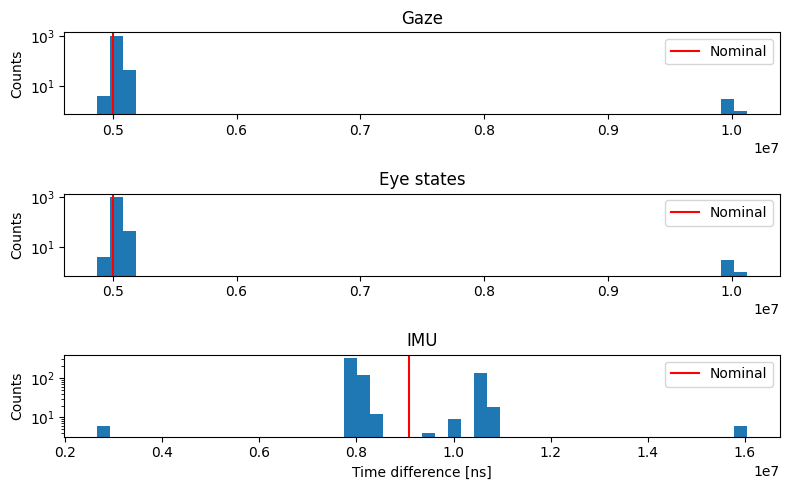

In [5]:
print(
    f"Nominal sampling frequency of gaze: {gaze.sampling_freq_nominal} Hz. "
    f"Actual: {gaze.sampling_freq_effective:.1f} Hz"
)
print(
    f"Nominal sampling frequency of eye states: {eye_states.sampling_freq_nominal} Hz. "
    f"Actual: {eye_states.sampling_freq_effective:.1f} Hz"
)
print(
    f"Nominal sampling frequency of IMU: {imu.sampling_freq_nominal} Hz. "
    f"Actual: {imu.sampling_freq_effective:.1f} Hz"
)

fig, axs = plt.subplots(3, 1, figsize=(8, 5), tight_layout=True)

axs[0].hist(gaze.ts_diff, bins=50)
axs[0].axvline(1e9 / gaze.sampling_freq_nominal, c="red", label="Nominal")
axs[0].set_title("Gaze")

axs[1].hist(eye_states.ts_diff, bins=50)
axs[1].axvline(1e9 / eye_states.sampling_freq_nominal, c="red", label="Nominal")
axs[1].set_title("Eye states")

axs[2].hist(imu.ts_diff, bins=50)
axs[2].axvline(1e9 / imu.sampling_freq_nominal, c="red", label="Nominal")
axs[2].set_title("IMU")
axs[2].set_xlabel("Time difference [ns]")

for i in range(3):
    axs[i].set_yscale("log")
    axs[i].set_ylabel("Counts")
    axs[i].legend()
plt.show()

## Sampling Irregularities in Practice

For gaze and eye states streams, the distribution of inter-sample intervals is centered around the nominal rate, but some integer multiples indicate occasional dropped frames from the eye camera. For IMU streams, the distribution shows more variation.

## Interpolating Data Streams to Regular Sampling

When you need to perform analyses that assume continuous, uniformly-sampled data streams, interpolation becomes necessary. PyNeon uses `scipy.interpolate.interp1d` [(API reference)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) to interpolate stream data. The `interpolate()` method creates a new `Stream` object with data sampled at regular intervals.

By default, interpolation generates new timestamps starting from the stream's first timestamp, with uniform spacing determined by the nominal sampling frequency specified by Pupil Labs (200 Hz for gaze and eye states, 110 Hz for IMU).

In [6]:
# Interpolate to the nominal sampling frequency
gaze_interp = gaze.interpolate()

# Three ways you can check if the interpolation was successful:
# 1. Compare the effective sampling frequency to the nominal sampling frequency
print(
    f"Nominal sampling frequency of gaze: {gaze_interp.sampling_freq_nominal} Hz. "
    f"Actual (after interpolation): {gaze_interp.sampling_freq_effective:.1f} Hz"
)
# 2. Check the number of unique time differences
print(f"Only one unique time difference: {np.unique(gaze_interp.ts_diff)}")
# 3. Call the `is_uniformly_sampled` property (boolean)
print(f"The new gaze stream is uniformly sampled: {gaze_interp.is_uniformly_sampled}")
print(gaze_interp.data.dtypes)

Nominal sampling frequency of gaze: 200 Hz. Actual (after interpolation): 200.2 Hz
Only one unique time difference: [5000000]
The new gaze stream is uniformly sampled: True
gaze x [px]        float64
gaze y [px]        float64
worn               float64
azimuth [deg]      float64
elevation [deg]    float64
dtype: object


Note that column data types are preserved after interpolation (float columns remain float, integer columns remain integer, etc.). You can also interpolate a stream to specific custom timestamps by providing the `new_ts` parameter. This is especially helpful when synchronizing multiple streams with different sampling rates. For example, you can interpolate gaze data (~200 Hz) to match the timestamps of IMU data (~110 Hz):

In [7]:
print(f"Original gaze data length: {len(gaze)}")
print(f"Original IMU data length: {len(imu)}")
gaze_interp_to_imu = gaze.interpolate(new_ts=imu.ts)
print(
    f"Gaze data length after interpolating to IMU timestamps: {len(gaze_interp_to_imu)}"
)

Original gaze data length: 1048
Original IMU data length: 622
Gaze data length after interpolating to IMU timestamps: 622


C:\Users\User\Documents\GitHub\PyNeon\pyneon\preprocess\preprocess.py:66: UserWarning: 18 out of 622 requested timestamps are outside the data time range and will have empty data.
  warn(


### Interpolation Details

By default, float-type data is interpolated using linear interpolation (`kind='linear'`). Other data types use nearest-neighbor interpolation. Let's examine how linear interpolation handles the irregular gaze data:

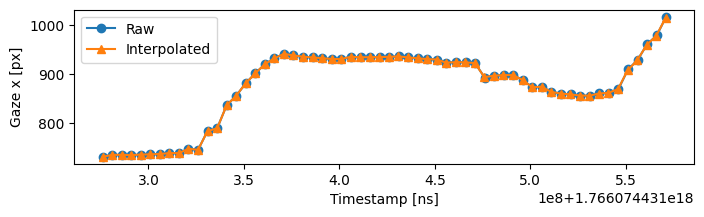

In [8]:
gaze_interp_begin = gaze_interp.restrict(gaze_begin)

plt.figure(figsize=(8, 2))
plt.plot(gaze_begin["gaze x [px]"], marker="o", label="Raw")
plt.plot(
    gaze_interp_begin["gaze x [px]"],
    marker="^",
    label="Interpolated",
)
plt.xlabel("Timestamp [ns]")
plt.ylabel("Gaze x [px]")
plt.legend()
plt.show()

## Concatenating Multiple Streams

Often you want to combine multiple streams into a single DataFrame for joint analysis (e.g., [epoching](pupil_size_and_epoching.ipynb)). The `concat_streams()` method of `Recording` handles this by:

1. Interpolating all specified streams to common timestamps
2. Combining them into a single `Stream` object with all columns

The common timestamps are defined by:
- **Start**: The latest (most recent) first timestamp across all streams
- **End**: The earliest (soonest) last timestamp across all streams
- **Sampling rate**: Configurable (defaults to the lowest nominal rate among the streams)

This ensures all original data is preserved while maintaining temporal alignment.

In [9]:
concat_stream = rec.concat_streams(["gaze", "eye_states", "imu"])
print(concat_stream.data.head())
print(concat_stream.data.columns)

Concatenating streams:
	gaze
	eye_states
	imu
Using lowest sampling rate: 110 Hz (<StringArray>
['imu']
Length: 1, dtype: str)
Using latest start timestamp: 1766074431275967547 (<StringArray>
['gaze', 'eye_states']
Length: 2, dtype: str)
Using earliest last timestamp: 1766074436535834547 (<StringArray>
['gaze', 'eye_states']
Length: 2, dtype: str)
                     gaze x [px]  gaze y [px]  worn  azimuth [deg]  \
timestamp [ns]                                                       
1766074431275967547   731.885864   503.253845    -1      -4.384848   
1766074431285058456   735.780922   499.996515    -1      -4.134103   
1766074431294149365   735.862011   502.149531    -1      -4.128883   
1766074431303240274   737.018387   503.200361    -1      -4.054441   
1766074431312331183   739.273033   502.726029    -1      -3.909299   

                     elevation [deg]  pupil diameter left [mm]  \
timestamp [ns]                                                   
1766074431275967547        

The visualization below shows how the concatenated stream has uniform sampling (matching the IMU's nominal rate) compared to the original streams' irregular sampling patterns. Notice how all three streams now have the same temporal resolution:

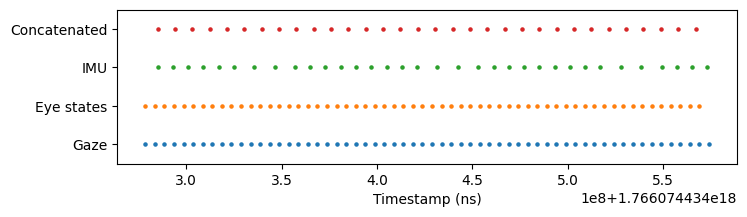

In [10]:
# Extract a time window from the middle of the recording to highlight sampling differences
gaze_middle = gaze.crop(tmin=3.0, tmax=3.3, by="time")
eye_states_middle = eye_states.restrict(gaze_middle)
imu_middle = imu.restrict(gaze_middle)
concat_stream_middle = concat_stream.restrict(gaze_middle)
plot_timestamps(gaze_middle, eye_states_middle, imu_middle, concat_stream_middle)

Despite being resampled to a uniform grid, the concatenated stream preserves the original data values. The columns from the original streams (like `gaze x [px]` and `acceleration x [g]`) retain their meaning and can be compared directly between raw and concatenated versions:

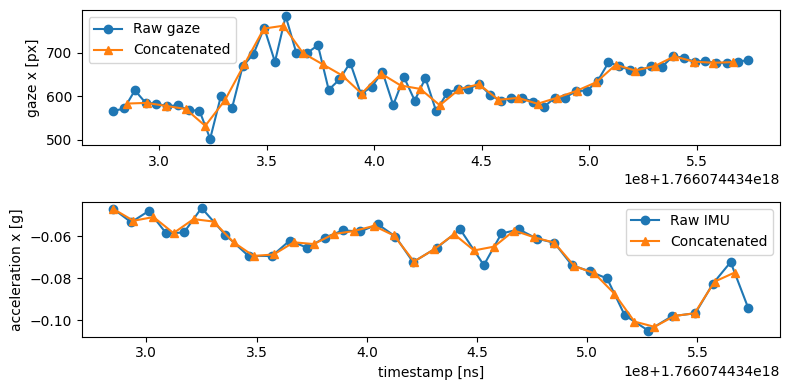

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)
axs[0].plot(
    gaze_middle["gaze x [px]"],
    marker="o",
    label="Raw gaze",
)
axs[0].plot(
    concat_stream_middle["gaze x [px]"],
    marker="^",
    label="Concatenated",
)
axs[0].set_ylabel("gaze x [px]")
axs[0].legend()
axs[1].plot(
    imu_middle["acceleration x [g]"],
    marker="o",
    label="Raw IMU",
)
axs[1].plot(
    concat_stream_middle["acceleration x [g]"],
    marker="^",
    label="Concatenated",
)
axs[1].set_ylabel("acceleration x [g]")
axs[1].set_xlabel("timestamp [ns]")
axs[1].legend()
plt.show()